In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install demoji

import re
import demoji
import random
import inflect
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
# Reading the text
file_path = "/content/drive/MyDrive/human_chat.txt"
with open(file_path, "r") as file:
  lines = file.readlines()

In [ ]:
lines

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n',
 'Human 2: Which holiday was that?\n',
 'Human 1: I think it was Australia\n',
 'Human 2: Do you still talk to the people you met?\n',
 "Human 1: Not really. The interactions are usually short-lived but it's fascinating to learn where people are coming from and what matters to them\n",
 'Human 2: Yea, me too. I feel like God often puts strangers in front of you, and gives you an opportunity to connect with them in that moment in deeply meaningful ways. Do you ever feel like you know things about strangers without them telling you?\n',
 'Human 1: what do you mean?\n',
 'Human 2: I think it\'s like a 6th sense, often seen as "cold readings" to people, but can be remarkably accurate. I once sat next to a man in a coffee and I felt

In [ ]:
len(lines)

1495

In [ ]:
def preprocess_text(text):
        # Remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()

        p = inflect.engine() #101
        demoji.download_codes()
        # Remove emojis
        text = demoji.replace(text, "")

        # Remove mentions of "Human 1" and "Human 2"
        text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

        # Replace numbers with words
        text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

        # Remove special characters, keeping only alphabetic and spaces
        text = re.sub('[^a-zA-Z\s]', ' ', text)

        # Replace specific unicode spaces with standard spaces and trim
        text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

        return text

In [ ]:
preprocessed_lines = [preprocess_text(line) for line in lines]

<ipython-input-6-77499133746e>:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
<ipython-input-6-77499133746e>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
preprocessed_lines[0:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

# Torchtext
Torchtext is a library within the PyTorch ecosystem designed to facilitate the preprocessing of textual data.

## get_tokenizer
. The get_tokenizer function is one of the core utilities provided by torchtext for tokenizing text data.

. get_tokenizer retrieves a tokenizer function based on the method specified. This tokenizer can then be used to convert strings of text into lists of tokens.
##Parameters
  
  tokenizer: This argument specifies the type of tokenizer to use. You can specify built-in tokenizers such as "basic_english", "spacy", "moses", or even provide a custom tokenizer function.

  language: Some tokenizers, like those based on the Moses or Spacy libraries, might require you to specify the language of the text, which influences how the text is tokenized (e.g., handling language-specific punctuation and splitting rules).

In [ ]:
tokenizer = get_tokenizer('basic_english')
tokenized_conv = [tokenizer(conv) for conv in preprocessed_lines]

In [ ]:
tokenized_conv[3]

['what',
 'was',
 'the',
 'most',
 'number',
 'of',
 'people',
 'you',
 'have',
 'ever',
 'met',
 'during',
 'a',
 'holiday']

## build_vocab_from_iterator
`build_vocab_from_iterator` function in the torchtext.vocab module is used to create a vocabulary from an iterable of tokenized data. This vocabulary is essential for converting textual data into numerical form.

#Parameters:
##tokenized_conv (iterator):
This is the main data input to the function. It should be an iterator (like a `generator` or a `list`) that yields sequences of tokens. Each sequence represents a document or an example in your dataset.
##min_freq (int, optional):
 This parameter specifies the minimum frequency a token must have to be included in the vocabulary. Tokens that appear fewer than min_freq times are excluded from the vocabulary. This is useful for removing rare words which might be typos or irrelevant to most analyses.
##specials (list of str, optional):
 This is a list of special tokens that you want to add to the vocabulary. Common special tokens include:
'<pad>': A padding token used to equalize the lengths of sequences.
'<oov>' (or '<unk>' for "unknown"): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not in the training vocabulary.
##special_first (bool, optional):
 Determines the ordering of special tokens in the vocabulary. If True, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant (e.g., models using embedding layers might have specific handling for lower indices).

In [ ]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1,
    specials=['<pad>', '<oov>'],
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1
)

In [ ]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [ ]:
print("Features Vocab Length", features_vocab_total_words)
print("Target_vocab_Length", target_vocab_total_words)

Features Vocab Length 2749
Target_vocab_Length 2747


In [ ]:
# making ngrams from the conversations
def make_ngrams(tokenized_text):
    list_ngrams = []
    for i in range(1, len(tokenized_text)):
        ngram_sequence = tokenized_text[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

In [ ]:
ngrams_list = []
for tokenized_con in tokenized_conv:
    ngrams_list.extend(make_ngrams(tokenized_con))

In [ ]:
# Add Random oov tokens to let the model handle oov tokens
def add_random_oov_tokens(ngram):
    for idx, word in enumerate(ngram[:-1]):
        if random.uniform(0, 1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

In [ ]:
ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_tokens(ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))

True


`get_itos`: stands for "index-to-string". The method returns a list where the indices in the list correspond to the numerical indices used in your model, and the values at those indices are the actual string representations (tokens).

In [ ]:
def text_to_numerical_sequence(tokenized_text):
    tokens_list = []
    if tokenized_text[-1] in target_vocab.get_itos():
        for token in tokenized_text[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

In [ ]:
input_sequences = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]

In [ ]:
print(f'Total input sequences: {len(input_sequences)}')
print(input_sequences[7:9])

Total input sequences: 18562
[[56, 90, 2, 73, 2], [56, 90, 2, 73, 4, 228]]


In [ ]:
X = [sequence[:-1] for sequence in input_sequences]
y = [sequence[-1] for sequence in input_sequences]
len(X[0]), y[0]

(1, 11)

In [ ]:
print(X[3],y[3])

[12, 1, 29, 120] 312


In [ ]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

153

`F.pad` function is a utility function which is part of torch.nn.functional module,used for padding tensors.
# Parameters:
##input (torch.tensor):
The tensor to be padded.
##pad (tuple of ints):
The number of values padded to the edges of each dimension. The tuple should contain pairs where each pair is the number of values added to the left and right of the dimension, respectively.
##value (scalar, optional):
The constant value used for constant padding. If the mode is 'constant' but no value is specified, it defaults to 0.

In [ ]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence),0), value=0) for sequence in X]
padded_X[1], X[2], len(padded_X[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  1, 13]),
 [12, 13, 29],
 153)

In [ ]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)

(torch.Tensor, torch.Tensor)

In [ ]:
y_one_hot = one_hot(y, num_classes=target_vocab_total_words)

# TensorDataset
`TensorDataset` is a subclass of `Dataset` that is specifically designed to handle scenarios where all data are already in the form of tensors. It wraps tensors, allowing you to access slices of these tensors as individual samples.

 It's particularly useful when your entire dataset is small enough to fit into memory, and you have pre-processed all of your input and target data into tensors. It simplifies the data loading during training when using a DataLoader since all data is already in tensor form and does not require further transformation or loading steps during the batch generation.

In [ ]:
data = TensorDataset(padded_X, y_one_hot)

In [ ]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32

In [ ]:
train_data, test_data = random_split(data, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class My_BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [ ]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
epochs = 50

In [ ]:
model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

My_BiLSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)

In [ ]:
def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
all_accuracies = []
all_losses = []
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())

Epoch 0/50, Loss: 2.6493, Train K-Accuracy: 20.25%
Epoch 5/50, Loss: 6.1609, Train K-Accuracy: 47.20%
Epoch 10/50, Loss: 0.2986, Train K-Accuracy: 80.23%
Epoch 15/50, Loss: 0.0375, Train K-Accuracy: 91.31%
Epoch 20/50, Loss: 3.4291, Train K-Accuracy: 94.43%
Epoch 25/50, Loss: 3.4429, Train K-Accuracy: 95.43%
Epoch 30/50, Loss: 1.4768, Train K-Accuracy: 95.78%
Epoch 35/50, Loss: 0.1096, Train K-Accuracy: 96.02%
Epoch 40/50, Loss: 0.4509, Train K-Accuracy: 96.11%
Epoch 45/50, Loss: 0.2099, Train K-Accuracy: 96.11%


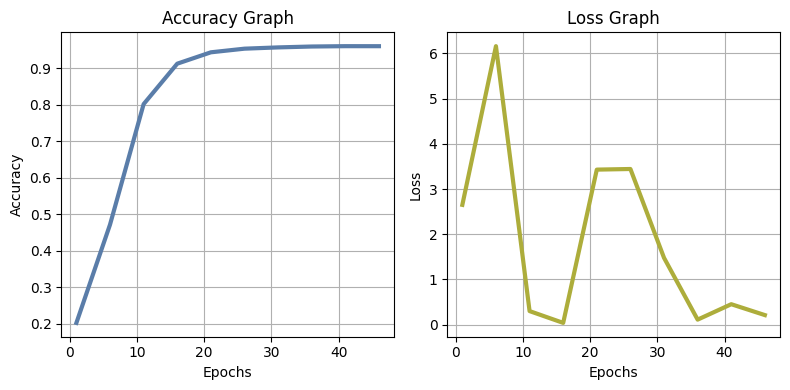

In [ ]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)

axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 19.31%


In [ ]:
model_path = '/content/drive/MyDrive/CampusX_Lecture/Day_3/my_bilstm_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/CampusX_Lecture/Day_3/my_bilstm_model.pth


In [ ]:
model_path = '/content/drive/MyDrive/CampusX_Lecture/Day_3/my_bilstm_model.pth'
torch.save(model, model_path)
print(f'Model saved to {model_path}')

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [ ]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
saved_model = BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim)

In [ ]:
model_path = '/content/drive/MyDrive/CampusX_Lecture/Day_3/my_bilstm_model.pth'
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

In [ ]:
def use_model(input_list, top_k=5):
    saved_model.eval()
    output_list = []
    for data in input_list:
        sentence = data[0]
        num_words = data[1]
        for i in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                         (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0),
                                                         value=0)
            output_test_walking = model(padded_tokenized_sequence_input_test.unsqueeze(0))
            # Get the top k predictions and their indices
            top_predictions = torch.topk(output_test_walking, top_k)
            # Iterate over the top predictions
            for index in top_predictions.indices.squeeze():
                # Lookup the token for each index and append it to the output sentence
                sentence_with_predictions = sentence + ' ' + target_vocab.lookup_token(index.item())
                output_list.append(sentence_with_predictions)
        # Update the input sentence with the last predicted word
        sentence = output_list[-1]
    return output_list

In [ ]:
input_test = [['Hi', 1], ['Hello', 1]]

In [ ]:
outputs_model = use_model(input_test,5)
outputs_model

['Hi how are',
 'Hi how s',
 'Hi how was',
 'Hi how you',
 'Hi how about',
 'Hello there how',
 'Hello there who',
 'Hello there s',
 'Hello there is',
 'Hello there i']

## Code in Format of Classes

In [ ]:
class TextProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.p = inflect.engine()
        demoji.download_codes()

    def read_file(self):
        with open(self.file_path, "r") as file:
            return file.readlines()

    def preprocess_text(self, text):
        # Remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()

        # Remove emojis
        text = demoji.replace(text, "")

        # Remove mentions of "Human 1" and "Human 2"
        text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

        # Replace numbers with words
        text = re.sub(r'\b\d+\b', lambda x: self.p.number_to_words(x.group()), text)

        # Remove special characters, keeping only alphabetic and spaces
        text = re.sub('[^a-zA-Z\s]', ' ', text)

        # Replace specific unicode spaces with standard spaces and trim
        text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

        return text

    def preprocess_lines(self):
        lines = self.read_file()
        preprocessed_lines = [self.preprocess_text(line) for line in lines]
        return preprocessed_lines

In [ ]:
file_path = "/content/drive/MyDrive/human_chat.txt"

processor = TextProcessor(file_path)
preprocessed_lines = processor.preprocess_lines()

In [ ]:
class TextTokenizerAndVectorizer:
    def __init__(self, conversations, oov_rate=0.1, specials=['<pad>', '<oov>']):
        self.tokenizer = get_tokenizer('basic_english')
        self.conversations = conversations
        self.oov_rate = oov_rate
        self.specials = specials
        self.tokenized_text = [self.tokenizer(conv) for conv in conversations]
        self.features_vocab = self.build_vocab(special_first=True)
        self.target_vocab = self.build_vocab(special_first=False)
        self.num_classes = len(self.target_vocab)

    def build_vocab(self, special_first=True):
        specials = self.specials if special_first else []
        return build_vocab_from_iterator(
            self.tokenized_text,
            min_freq=1,
            specials=specials,
            special_first=special_first
        )

    def make_ngrams(self, text):
        ngrams = []
        for i in range(1, len(text)):
            ngram_sequence = text[:i+1]
            ngrams.append(ngram_sequence)
        return ngrams

    def add_random_oov_tokens(self, ngram):
        for idx, word in enumerate(ngram[:-1]):
            if random.uniform(0, 1) < self.oov_rate:
                ngram[idx] = '<oov>'
        return ngram

    def text_to_numerical_sequence(self, tokenized_text):
        tokens_list = []
        if tokenized_text[-1] in self.target_vocab.get_itos():
            for token in tokenized_text[:-1]:
                num_token = self.features_vocab[token] if token in self.features_vocab.get_itos() else self.features_vocab['<oov>']
                tokens_list.append(num_token)
            num_token = self.target_vocab[tokenized_text[-1]]
            tokens_list.append(num_token)
            return tokens_list
        return None

    def process_text(self):
        ngrams_list = [ngram for text in self.tokenized_text for ngram in self.make_ngrams(text)]
        ngrams_list_oov = [self.add_random_oov_tokens(ngram) for ngram in ngrams_list]
        input_sequences = [self.text_to_numerical_sequence(seq) for seq in ngrams_list_oov if self.text_to_numerical_sequence(seq)]

        X = [seq[:-1] for seq in input_sequences]
        y = [seq[-1] for seq in input_sequences]
        longest_sequence_feature = max(len(seq) for seq in X)

        padded_X = torch.stack([F.pad(torch.tensor(seq), (longest_sequence_feature - len(seq),0), value=self.features_vocab['<pad>']) for seq in X])
        y = torch.tensor(y)
        y_one_hot = one_hot(y, num_classes=self.num_classes)

        return padded_X, y_one_hot, len(self.features_vocab), len(self.target_vocab)

In [ ]:
txt_processor = TextTokenizerAndVectorizer(preprocessed_lines)
X, y, features_vocab_total_words, target_vocab_total_words = txt_processor.process_text()

In [ ]:
# Assuming X and y are your features and targets tensors respectively
data = TensorDataset(X, y)

# Calculate split sizes
total_size = len(data)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum of splits equals total_size

# Split the dataset
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class My_BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        # Specify bidirectional=True to use a BiLSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        # Since it's bidirectional, concatenate the hidden states from both directions
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [ ]:
embedding_dim = 128
hidden_dim = 256
epochs = 50
model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [ ]:
class BiLSTMTrainer:
    def __init__(self, model, train_loader, val_loader=None, epochs=50, lr=0.0009, device=None, k=3, patience=5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.best_val_loss = float('inf')
        self.k = k
        self.patience = patience

    def calculate_topk_accuracy(self, data_loader):
        self.model.eval()
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                output = self.model(batch_x)
                _, predicted_indices = output.topk(self.k, dim=1)
                correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
                total_predictions += batch_y.size(0)

        accuracy = correct_predictions / total_predictions
        return accuracy

    def train(self):

        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []
        count = 0

        for epoch in range(self.epochs):
            self.model.train()
            epoch_losses = []
            for batch_X, batch_y in self.train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y.argmax(dim=1))
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())

            avg_loss = sum(epoch_losses) / len(epoch_losses)
            train_losses.append(avg_loss)

            if self.val_loader:
                val_loss = self.validate()
                val_losses.append(val_loss)
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    torch.save(model.state_dict(), 'best_model.pth')
                    print(f'new best validation loss: {val_loss:.4f}')
                    count = 0
                else:
                    count += 1
                    if count > self.patience:
                      print(f'Early stopping at epoch {epoch + 1}')
                      break  # Early stopping condition

            train_accuracy = self.calculate_topk_accuracy(self.train_loader)
            val_accuracy = self.calculate_topk_accuracy(self.val_loader)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 5 == 0:
                print(f'Epoch {epoch}/{self.epochs} ||Train Loss: {avg_loss:.4f} || Train K-Accuracy: {train_accuracy * 100:.2f}% || Val Loss :{val_loss:.4f} || Validation K-Accuracy: {val_accuracy * 100:.2f}%')

        self.plot_results(train_accuracies, train_losses, val_accuracies, val_losses)

    def validate(self):
        self.model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_x, batch_y in self.val_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y.argmax(dim=1))
                val_losses.append(loss.item())
        return sum(val_losses) / len(val_losses)

    def plot_results(self, train_accuracies, train_losses, val_accuracies, val_losses):

        epochs_x = list(range(1, len(train_accuracies) + 1))
        epochs_x_ = list(range(1, len(train_losses) + 1))
        plt.figure(figsize=(12, 6))

        # Creating two y-axes
        fig, ax1 = plt.subplots()

        # Plotting training and validation accuracies
        plt.subplot(1, 2, 1)
        plt.plot(epochs_x, train_accuracies, 'b-o', label='Train Accuracy')
        plt.plot(epochs_x, val_accuracies, 'r-+', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')

        # Plotting training and validation losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs_x_, train_losses, 'g-o', label='Train Loss')
        plt.plot(epochs_x_, val_losses, 'k-+', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()

In [ ]:
trainer = BiLSTMTrainer(model, train_loader=train_loader, val_loader=val_loader)

In [ ]:
trainer.train()